In [1]:
pip install pandas numpy rdkit seaborn matplotlib

In [2]:
import pandas as pd
import numpy as np

# ==========================================
# 1. 加载数据
# ==========================================
file_path = 'C:/Users/tinid/polymer/20years乙醇数据.csv'
output_file = 'Z-Score去除.csv'

print(f"--- 正在读取数据: {file_path} ---")
try:
    # 尝试默认编码读取
    df = pd.read_csv(file_path)
except UnicodeDecodeError:
    # 如果报错，尝试 GBK 编码（处理中文常见问题）
    df = pd.read_csv(input_file, encoding='gbk')

print(f"原始数据加载成功，共 {len(df)} 行。")

# ==========================================
# 2. 预处理：删除目标变量缺失的行
# ==========================================
target_col = 'Separation factor'

# 如果没有分离因子，这行数据对训练毫无意义，必须删除
df = df.dropna(subset=[target_col]).copy()
print(f"删除目标变量缺失行后，剩余 {len(df)} 行。")

# ==========================================
# 3. 核心步骤：Z-Score 异常值剔除
# ==========================================
print("\n--- 正在剔除异常值 (Z-Score > 3) ---")

# 1. 对数变换 (Log10)
# 分离因子通常是长尾分布，取对数后才符合正态分布假设，Z-Score 才有效
df['log_target'] = np.log10(df[target_col])

# 2. 计算 Z-Score
mean_val = df['log_target'].mean()
std_val = df['log_target'].std()

# z = |(x - mean) / std|
z_scores = np.abs((df['log_target'] - mean_val) / std_val)

# 3. 筛选数据
threshold = 3  # 阈值：3倍标准差
df_clean = df[z_scores <= threshold].copy()

# 4. 统计结果
n_removed = len(df) - len(df_clean)
print(f"检测阈值: {threshold} 倍标准差")
print(f"剔除了 {n_removed} 个异常值。")
print(f"剩余有效数据: {len(df_clean)} 行。")

# ==========================================
# 4. 保存结果
# ==========================================
# 删除辅助列 (可选，如果您不想保留 log_target 列，取消下面这行的注释)
# df_clean.drop(columns=['log_target'], inplace=True)

df_clean.to_csv(output_file, index=False)
print(f"\n✅ 处理完成！文件已保存为: {output_file}")

# 打印前 5 行预览
print("\n数据预览:")
print(df_clean[[target_col, 'log_target']].head())

--- 正在读取数据: C:/Users/tinid/polymer/20years乙醇数据.csv ---
原始数据加载成功，共 1081 行。
删除目标变量缺失行后，剩余 1074 行。

--- 正在剔除异常值 (Z-Score > 3) ---
检测阈值: 3 倍标准差
剔除了 16 个异常值。
剩余有效数据: 1058 行。

✅ 处理完成！文件已保存为: Z-Score去除.csv

数据预览:
   Separation factor  log_target
0            1144.13    3.058475
1             849.16    2.928990
2             560.15    2.748304
3             443.95    2.647334
4             405.21    2.607680


In [3]:
import pandas as pd
import numpy as np

# ==========================================
# 第一步：加载数据
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/Z-Score去除.csv'  # 确保文件名正确
print("正在读取数据...")

try:
    df = pd.read_csv(file_path)
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='gbk')

print(f"原始数据加载成功，共 {len(df)} 行。")

# ==========================================
# 第二步：定义“什么是重复实验”
# ==========================================
# 我们认为：如果以下列的值都相同，就是同一次实验
group_cols = [
    'Permeation type',          # 渗透类型
    'Temperature',              # 温度
    'Downstream pressure',      # 下游压力
    'Solvent concentration',    # 溶剂浓度
    'Thickness',                # 膜厚度
    'Polymer concentration',    # 聚合物浓度
    'Crosslinker concentration',# 交联剂浓度
]

print(f"\n正在根据以下条件检查重复: {group_cols}")

# ==========================================
# 第三步：执行合并 (关键技巧)
# ==========================================

# 1. 临时填充缺失值
# Pandas 的 groupby 会默认丢弃包含 NaN 的行，所以我们先用一个不可能的数字 (-999) 填充空值
# 这样，两个都是“空”的条件也会被视为“相同”的条件
df_filled = df.fillna(-999)

# 2. 定义聚合规则
# 数值结果取平均，文本信息取第一个
agg_dict = {
    'Separation factor': 'mean',
    'Flux': 'mean',
    # 以下列只保留第一条记录的信息
    'polymer': 'first',
    'Hildebrand-parameters': 'first',
    'Monomer molecular weight': 'first',
    'Area': 'first',
    'DOI': 'first'
}

# 3. 分组并聚合
df_grouped = df_filled.groupby(group_cols).agg(agg_dict).reset_index()

# 4. 还原缺失值
# 把之前的 -999 变回 NaN
for col in group_cols:
    if col in df_grouped.columns:
        # 如果是数值列
        if pd.api.types.is_numeric_dtype(df_grouped[col]):
            df_grouped[col] = df_grouped[col].replace(-999, np.nan)
        # 如果是字符串列 (比如 smiles)
        else:
            df_grouped[col] = df_grouped[col].replace(-999, None)

# ==========================================
# 第四步：保存结果
# ==========================================
print(f"\n合并完成！")
print(f"原始行数: {len(df)}")
print(f"合并后行数: {len(df_grouped)}")
print(f"减少了 {len(df) - len(df_grouped)} 行重复/冲突数据。")

# 保存
output_file = '去除重复数据.csv'
df_grouped.to_csv(output_file, index=False)

print(f"\n文件已保存为: {output_file}")

正在读取数据...
原始数据加载成功，共 1058 行。

正在根据以下条件检查重复: ['Permeation type', 'Temperature', 'Downstream pressure', 'Solvent concentration', 'Thickness', 'Polymer concentration', 'Crosslinker concentration']

合并完成！
原始行数: 1058
合并后行数: 922
减少了 136 行重复/冲突数据。

文件已保存为: 去除重复数据.csv


In [4]:
import pandas as pd
import numpy as np
# 必须显式导入 enable_iterative_imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# ==========================================
# 1. 加载数据
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/去除重复数据.csv'
output_file = 'MICE填补.csv'

print(f"--- 正在读取数据: {file_path} ---")
try:
    df = pd.read_csv(file_path)
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='gbk')

print(f"原始形状: {df.shape}")

# ==========================================
# 2. 预处理：处理占位符 -999
# ==========================================
# 这一步非常关键！如果不把 -999 变成 NaN，模型会认为它是一个真实的数值(-999)，
# 从而导致填补结果极度偏斜。
df_clean = df.replace([-999, -999.0], np.nan)

# 检查一下还有多少缺失值
print("处理 -999 后各列的缺失值数量:")
print(df_clean.isnull().sum())

# ==========================================
# 3. 准备 MICE 填补
# ==========================================
# 定义数值型列
numeric_features = [
    'Hildebrand-parameters', 
    'Monomer molecular weight', 
    'Polymer concentration', 
    'Crosslinker concentration',
    'Area', 
    'Thickness', 
    'Downstream pressure', 
    'Temperature', 
    'Solvent concentration', 
    'Flux', 
    'Separation factor',
    'Permeation type'
]

# 确保列存在
existing_numeric = [c for c in numeric_features if c in df_clean.columns]
data_matrix = df_clean[existing_numeric].copy()

print(f"\n--- 开始执行 MICE 填补 (RandomForest) ---")
# 初始化填补器
mice_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
    max_iter=10,
    random_state=42,
    verbose=1
)

# 训练并转换
data_imputed = mice_imputer.fit_transform(data_matrix)

# ==========================================
# 4. 整合结果
# ==========================================
df_final = df_clean.copy()
df_final[existing_numeric] = data_imputed

# 后处理：Permeation type (0/1分类变量) 四舍五入
if 'Permeation type' in df_final.columns:
    df_final['Permeation type'] = df_final['Permeation type'].round()

# 检查是否还有缺失
missing_count = df_final[existing_numeric].isnull().sum().sum()
print(f"\n✅ 填补完成！剩余缺失值: {missing_count}")

# 保存
df_final.to_csv(output_file, index=False)
print(f"文件已保存为: {output_file}")

# 预览前5行
print("\n数据预览:")
print(df_final[['Temperature', 'Polymer concentration', 'Flux']].head())

--- 正在读取数据: C:/Users/tinid/polymer/major revision/去除重复数据.csv ---
原始形状: (922, 14)
处理 -999 后各列的缺失值数量:
Permeation type                1
Temperature                   71
Downstream pressure          151
Solvent concentration         69
Thickness                    192
Polymer concentration        241
Crosslinker concentration    293
Separation factor              0
Flux                          51
polymer                        0
Hildebrand-parameters         19
Monomer molecular weight      38
Area                         251
DOI                            0
dtype: int64

--- 开始执行 MICE 填补 (RandomForest) ---
[IterativeImputer] Completing matrix with shape (922, 12)
[IterativeImputer] Change: 117779.99530688088, scaled tolerance: 1003.2112 
[IterativeImputer] Change: 50413.99012968328, scaled tolerance: 1003.2112 
[IterativeImputer] Change: 35070.06144819338, scaled tolerance: 1003.2112 
[IterativeImputer] Change: 37132.83564796671, scaled tolerance: 1003.2112 
[IterativeImputer] Change: 50

C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# ==========================================
# 1. 加载数据
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/MICE填补.csv' 
output_file = '标准化数据.csv'

try:
    df = pd.read_csv(file_path)
    print(f"成功加载文件: {file_path}")
except FileNotFoundError:
    print(f"错误: 未找到文件 {file_path}。请确保文件路径正确。")
    exit()

# ==========================================
# 2. 特殊处理：定义元数据和特殊列
# ==========================================
# 1. 元数据 (不参与训练，原样保留)
meta_cols = ['DOI', 'polymer'] 

# 2. 明确指定分类特征 (不进行标准化，而是做 One-Hot)
# 哪怕 Permeation type 是数字，我们也强制把它当分类处理
forced_categorical_cols = ['Permeation type'] 

# 分离元数据
df_meta = pd.DataFrame()
for col in meta_cols:
    if col in df.columns:
        df_meta[col] = df[col]
        df = df.drop(columns=[col])

# ==========================================
# 3. 分离特征 (X) 和 目标变量 (y)
# ==========================================
target_col = 'Separation factor'

if target_col in df.columns:
    X = df.drop(columns=[target_col])
    y = df[target_col]
else:
    X = df
    y = None

# ==========================================
# 4. 自动识别 + 手动修正特征类型
# ==========================================
# 先自动识别
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# 【关键修改】检查 Permeation type 是否被误判为数值列
for col in forced_categorical_cols:
    if col in numerical_cols:
        print(f"修正: 将 '{col}' 从数值特征移动到分类特征。")
        numerical_cols.remove(col)
        categorical_cols.append(col)

print(f"\n--- 特征工程方案 ---")
print(f"标准化 (StandardScaler): {numerical_cols}")
print(f"独热编码 (OneHotEncoder): {categorical_cols}")

# ==========================================
# 5. 构建预处理管道
# ==========================================
transformers = []

# 数值特征 -> 标准化
if numerical_cols:
    transformers.append(('num', StandardScaler(), numerical_cols))

# 分类特征 -> 独热编码
if categorical_cols:
    transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    verbose_feature_names_out=False
)

# ==========================================
# 6. 执行转换
# ==========================================
print("\n正在执行处理...")
X_scaled = preprocessor.fit_transform(X)

# 获取新列名
try:
    new_cols = []
    if numerical_cols:
        new_cols += numerical_cols
    if categorical_cols:
        # 获取 OneHot 后的列名
        cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
        new_cols += list(cat_names)
except AttributeError:
    new_cols = numerical_cols # 旧版本兼容

df_scaled = pd.DataFrame(X_scaled, columns=new_cols)

# ==========================================
# 7. 最终拼接
# ==========================================
parts = []
if not df_meta.empty: parts.append(df_meta.reset_index(drop=True)) # 元数据
parts.append(df_scaled) # 特征
if y is not None: parts.append(y.reset_index(drop=True)) # 目标

df_final = pd.concat(parts, axis=1)

# 保存
df_final.to_csv(output_file, index=False)
print(f"\n✅ 处理完成！文件已保存为: {output_file}")
print("Permeation type 已作为分类特征处理（One-Hot），未进行标准化。")
print(df_final.head())

成功加载文件: C:/Users/tinid/polymer/major revision/MICE填补.csv
修正: 将 'Permeation type' 从数值特征移动到分类特征。

--- 特征工程方案 ---
标准化 (StandardScaler): ['Temperature', 'Downstream pressure', 'Solvent concentration', 'Thickness', 'Polymer concentration', 'Crosslinker concentration', 'Flux', 'Hildebrand-parameters', 'Monomer molecular weight', 'Area']
独热编码 (OneHotEncoder): ['Permeation type']

正在执行处理...

✅ 处理完成！文件已保存为: 标准化数据.csv
Permeation type 已作为分类特征处理（One-Hot），未进行标准化。
                            DOI polymer  Temperature  Downstream pressure  \
0  10.1016/j.memsci.2011.08.060    PDMS     0.722739            -0.358626   
1  10.1016/j.seppur.2021.119897      CS     0.269807             0.394389   
2  10.1016/j.seppur.2021.119897      CS     0.155180             0.396077   
3  10.1016/j.seppur.2021.119897      CS     0.341062             0.541738   
4  10.1016/j.seppur.2021.119897      CS     0.325572            -0.195652   

   Solvent concentration  Thickness  Polymer concentration  \
0              -0.24

成功加载文件: C:/Users/tinid/polymer/major revision/标准化数据.csv

正在对目标变量 'Separation factor' 进行 Log10 变换...
变换完成！
原始目标: Separation factor (已删除)
新目标:   log_Separation_factor

--- 新目标变量统计描述 ---
count    922.000000
mean       1.537899
std        0.863813
min       -0.202940
25%        0.872583
50%        1.255273
75%        2.204950
max        4.330414
Name: log_Separation_factor, dtype: float64

✅ 最终训练数据已保存为: 对数变换.csv


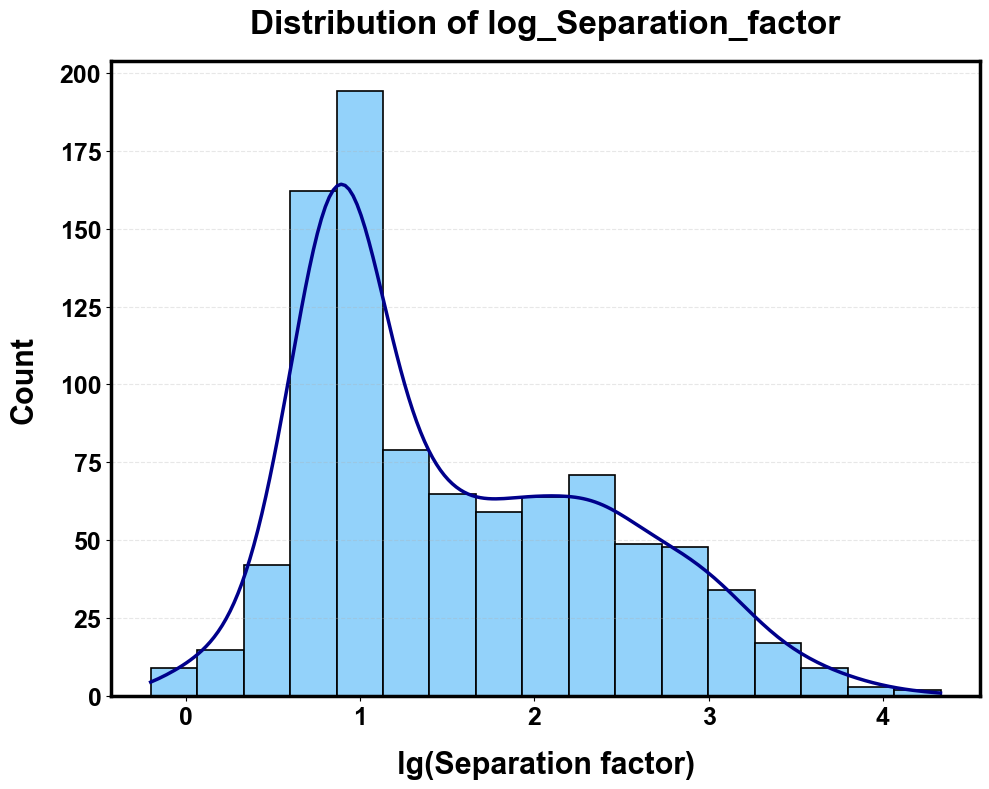

分布图已生成。


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 加载上一阶段的数据 (标准化后的数据)
# ==========================================
# 请根据实际情况修改路径
file_path = 'C:/Users/tinid/polymer/major revision/标准化数据.csv' 
output_file = '对数变换.csv'

try:
    df = pd.read_csv(file_path)
    print(f"成功加载文件: {file_path}")
except FileNotFoundError:
    print(f"错误: 找不到文件 {file_path}。请确保上一步的标准化代码已运行。")
    exit()

# ==========================================
# 2. 执行 Log10 变换
# ==========================================
target_col = 'Separation factor'
new_target_col = 'log_Separation_factor'

if target_col in df.columns:
    print(f"\n正在对目标变量 '{target_col}' 进行 Log10 变换...")
    
    # 检查是否有 <= 0 的值
    if (df[target_col] <= 0).any():
        print("警告: 目标变量中存在 <= 0 的数值，这些行将被移除。")
        df = df[df[target_col] > 0].copy()
    
    # 执行变换
    df[new_target_col] = np.log10(df[target_col])
    
    # 删除原始列防止泄露
    df = df.drop(columns=[target_col])
    
    print("变换完成！")
    print(f"原始目标: {target_col} (已删除)")
    print(f"新目标:   {new_target_col}")

else:
    print(f"错误: 数据中未找到列 '{target_col}'")
    exit()

# ==========================================
# 3. 验证变换效果 (可视化 - 最终修正版)
# ==========================================
# 打印统计描述
print("\n--- 新目标变量统计描述 ---")
print(df[new_target_col].describe())

# 保存最终文件
df.to_csv(output_file, index=False)
print(f"\n✅ 最终训练数据已保存为: {output_file}")

# --- 绘图部分 ---
try:
    # 设置全局字体为 Arial
    plt.rcParams['font.family'] = 'Arial'
    
    # 调整画布大小
    plt.figure(figsize=(10, 8), facecolor='white')
    
    # 绘制直方图
    ax = sns.histplot(
        df[new_target_col], 
        kde=True, 
        color='#87CEFA',  # 淡蓝色
        edgecolor='black', 
        linewidth=1.2,
        alpha=0.9
    )
    
    # 修改 KDE 曲线颜色为深蓝
    if ax.lines:
        ax.lines[0].set_color('darkblue')
        ax.lines[0].set_linewidth(2.5)

    # 设置标题 (可选)
    plt.title(f'Distribution of {new_target_col}', fontsize=24, fontweight='bold', pad=20)
    
    # 【修改点】设置 X 轴标签：改为 lg(Separation factor)
    plt.xlabel('lg(Separation factor)', fontsize=22, fontweight='bold', fontname='Arial', labelpad=15)
    
    # 设置 Y 轴标签
    plt.ylabel('Count', fontsize=22, fontweight='bold', fontname='Arial', labelpad=15)
    
    # 设置刻度标签样式
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18, fontweight='bold')
    
    # 加粗边框 (Spines)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)
        spine.set_color('black')
    
    # 仅保留横向网格
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("分布图已生成。")
    
except Exception as e:
    print(f"绘图失败: {e}")

成功加载文件: C:/Users/tinid/polymer/major revision/MICE填补.csv
✅ 图片已保存至: C:/Users/tinid/polymer/major revision\MICE_Separation_factor_hist.png


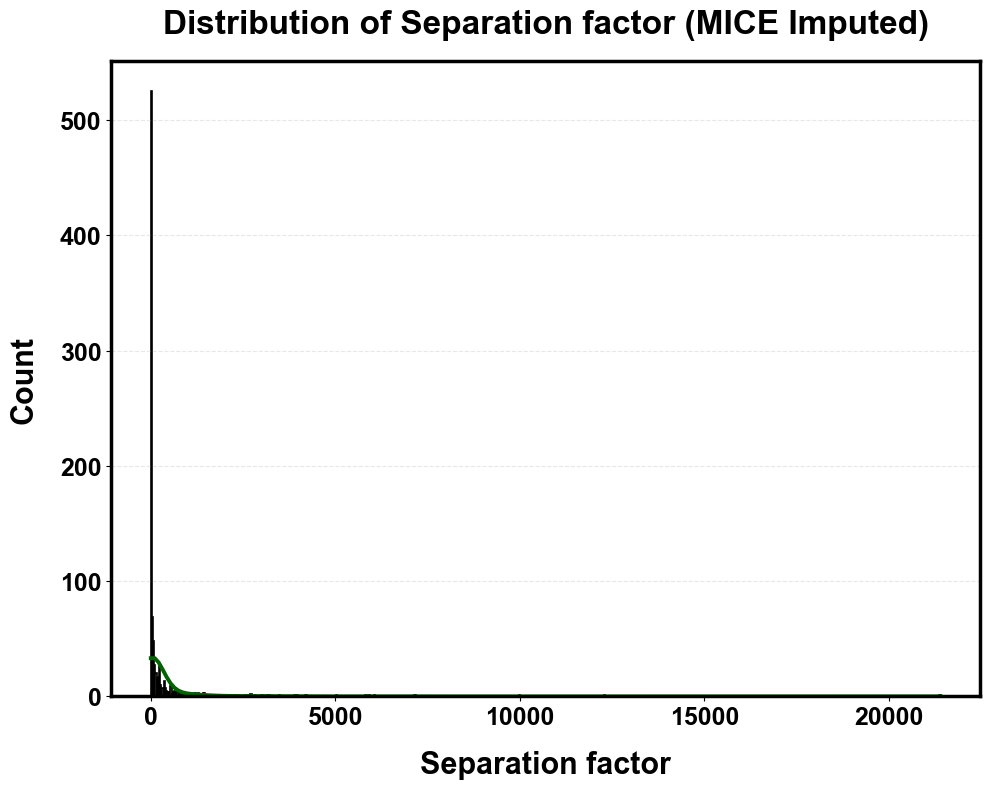

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. 加载数据
# ==========================================
# 假设文件名是 'MICE填补.csv'，请根据实际情况修改路径
# 这里尝试了您之前常用的路径
file_paths = ['C:/Users/tinid/polymer/major revision/MICE填补.csv']

df = None
loaded_path = ""

for path in file_paths:
    if os.path.exists(path): # 检查文件是否存在
        try:
            df = pd.read_csv(path)
            loaded_path = path
            print(f"成功加载文件: {loaded_path}")
            break
        except Exception as e:
            print(f"尝试加载 {path} 失败: {e}")

if df is None:
    print("❌ 错误: 未能在常用路径找到 'MICE填补' 相关CSV文件。")
    print("请确认文件名和路径是否正确。")
    # 为了防止代码报错停止，这里可以生成一个空的 DataFrame 或者退出
    # exit() 
else:
    # ==========================================
    # 2. 绘图 (Separation factor)
    # ==========================================
    target_col = 'Separation factor'

    if target_col in df.columns:
        # 设置全局字体
        plt.rcParams['font.family'] = 'Arial'
        
        plt.figure(figsize=(10, 8), facecolor='white')
        
        # 绘制直方图
        # color: 使用绿色 (#82B366) 呼应之前的 Separation Factor 风格
        # 也可以改为 '#87CEFA' (淡蓝) 或 '#FF9999' (淡红)
        ax = sns.histplot(
            df[target_col], 
            kde=True, 
            color='#82B366',  # <--- 绿色
            edgecolor='black', 
            linewidth=1.2,
            alpha=0.9
        )
        
        # 修改 KDE 曲线颜色为深绿色
        if ax.lines:
            ax.lines[0].set_color('darkgreen')
            ax.lines[0].set_linewidth(2.8)

        # 设置标题 (可选)
        plt.title(f'Distribution of {target_col} (MICE Imputed)', fontsize=24, fontweight='bold', pad=20)
        
        # X 轴标签
        plt.xlabel(target_col, fontsize=22, fontweight='bold', fontname='Arial', labelpad=15)
        
        # Y 轴标签
        plt.ylabel('Count', fontsize=22, fontweight='bold', fontname='Arial', labelpad=15)
        
        # 设置刻度标签样式
        plt.xticks(fontsize=18, fontweight='bold')
        plt.yticks(fontsize=18, fontweight='bold')
        
        # 加粗边框
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_linewidth(2.5)
            spine.set_color('black')
        
        # 网格
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        
        # 保存图片
        save_path = os.path.join(os.path.dirname(loaded_path), 'MICE_Separation_factor_hist.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 图片已保存至: {save_path}")
        
        plt.show()
        
    else:
        print(f"❌ 错误: 数据集中未找到列 '{target_col}'。")
        print(f"可用列名: {df.columns.tolist()}")

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# ==========================================
# 1. 加载数据
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/MICE填补.csv' 
output_file = '标准化数据_无独热编码.csv'

try:
    df = pd.read_csv(file_path)
    print(f"成功加载文件: {file_path}")
except FileNotFoundError:
    print(f"错误: 未找到文件 {file_path}。请确保文件路径正确。")
    exit()

# ==========================================
# 2. 特殊处理：定义元数据和特殊列
# ==========================================
# 1. 元数据 (不参与训练，原样保留)
meta_cols = ['DOI', 'polymer'] 

# 2. 明确指定分类特征 (不进行标准化，也不进行独热编码，仅保留原样)
# 哪怕 Permeation type 是数字，我们也强制把它划分为分类特征，从而避免被标准化
forced_categorical_cols = ['Permeation type'] 

# 分离元数据
df_meta = pd.DataFrame()
for col in meta_cols:
    if col in df.columns:
        df_meta[col] = df[col]
        df = df.drop(columns=[col])

# ==========================================
# 3. 分离特征 (X) 和 目标变量 (y)
# ==========================================
target_col = 'Separation factor'

if target_col in df.columns:
    X = df.drop(columns=[target_col])
    y = df[target_col]
else:
    X = df
    y = None

# ==========================================
# 4. 自动识别 + 手动修正特征类型
# ==========================================
# 先自动识别
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# 【关键修改】检查 forced_categorical_cols 是否被误判为数值列
# 这一步是为了防止它们被 StandardScaler 标准化
for col in forced_categorical_cols:
    if col in numerical_cols:
        print(f"修正: 将 '{col}' 从数值特征移动到分类特征 (防止被标准化)。")
        numerical_cols.remove(col)
        # 避免重复添加
        if col not in categorical_cols:
            categorical_cols.append(col)

print(f"\n--- 特征工程方案 ---")
print(f"执行标准化 (StandardScaler): {numerical_cols}")
print(f"保持原样 (Passthrough): {categorical_cols}")

# ==========================================
# 5. 构建预处理管道
# ==========================================
transformers = []

# 数值特征 -> 标准化
if numerical_cols:
    transformers.append(('num', StandardScaler(), numerical_cols))

# 分类特征 -> 【修改点】保持原样 ('passthrough')，不进行独热编码
if categorical_cols:
    transformers.append(('cat', 'passthrough', categorical_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    verbose_feature_names_out=False
)

# ==========================================
# 6. 执行转换
# ==========================================
print("\n正在执行处理...")
# ColumnTransformer 返回的是 numpy 数组
X_scaled = preprocessor.fit_transform(X)

# 获取新列名
try:
    new_cols = []
    # 注意：列的顺序必须与 transformers 添加的顺序一致
    if numerical_cols:
        new_cols += numerical_cols
    if categorical_cols:
        # 对于 passthrough，列名就是原始列名
        new_cols += categorical_cols
except AttributeError:
    # 备用方案
    new_cols = numerical_cols + categorical_cols

df_scaled = pd.DataFrame(X_scaled, columns=new_cols)

# ==========================================
# 7. 最终拼接
# ==========================================
parts = []
if not df_meta.empty: parts.append(df_meta.reset_index(drop=True)) # 元数据
parts.append(df_scaled) # 特征
if y is not None: parts.append(y.reset_index(drop=True)) # 目标

df_final = pd.concat(parts, axis=1)

# 保存
df_final.to_csv(output_file, index=False)
print(f"\n✅ 处理完成！文件已保存为: {output_file}")
print("数值特征已标准化，分类特征（含 Permeation type）已保留原值。")
print(df_final.head())

成功加载文件: C:/Users/tinid/polymer/major revision/MICE填补.csv
修正: 将 'Permeation type' 从数值特征移动到分类特征 (防止被标准化)。

--- 特征工程方案 ---
执行标准化 (StandardScaler): ['Temperature', 'Downstream pressure', 'Solvent concentration', 'Thickness', 'Polymer concentration', 'Crosslinker concentration', 'Flux', 'Hildebrand-parameters', 'Monomer molecular weight', 'Area']
保持原样 (Passthrough): ['Permeation type']

正在执行处理...

✅ 处理完成！文件已保存为: 标准化数据_无独热编码.csv
数值特征已标准化，分类特征（含 Permeation type）已保留原值。
                            DOI polymer  Temperature  Downstream pressure  \
0  10.1016/j.memsci.2011.08.060    PDMS     0.722739            -0.358626   
1  10.1016/j.seppur.2021.119897      CS     0.269807             0.394389   
2  10.1016/j.seppur.2021.119897      CS     0.155180             0.396077   
3  10.1016/j.seppur.2021.119897      CS     0.341062             0.541738   
4  10.1016/j.seppur.2021.119897      CS     0.325572            -0.195652   

   Solvent concentration  Thickness  Polymer concentration  \
0        

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# ==========================================
# 1. 加载数据
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/MICE填补.csv' 
output_file = '标准化数据_无独热_Log变换.csv'

try:
    df = pd.read_csv(file_path)
    print(f"成功加载文件: {file_path}")
except FileNotFoundError:
    print(f"错误: 未找到文件 {file_path}。请确保文件路径正确。")
    exit()

# ==========================================
# 2. 特殊处理：定义元数据和特殊列
# ==========================================
# 1. 元数据 (不参与训练，原样保留)
meta_cols = ['DOI', 'polymer'] 

# 2. 明确指定分类特征 (不进行标准化，也不进行独热编码，仅保留原样)
forced_categorical_cols = ['Permeation type'] 

# 分离元数据
df_meta = pd.DataFrame()
for col in meta_cols:
    if col in df.columns:
        df_meta[col] = df[col]
        df = df.drop(columns=[col])

# ==========================================
# 3. 分离特征 (X) 和 目标变量 (y) 并进行 Log 变换
# ==========================================
target_col = 'Separation factor'

if target_col in df.columns:
    X = df.drop(columns=[target_col])
    
    # 【新增步骤】对目标变量 y 进行 Log10 变换
    # 注意：分离因子通常 > 0。如果数据中有 0 或负数，会报错。
    # 这里假设数据已清洗，均为正数。
    print(f"\n正在对目标变量 '{target_col}' 进行 log10 变换...")
    y = np.log10(df[target_col])
    
    # 重命名列名，防止混淆
    y.name = f'log_{target_col}'
else:
    print(f"警告：未找到目标列 {target_col}，将跳过 y 的处理。")
    X = df
    y = None

# ==========================================
# 4. 自动识别 + 手动修正特征类型
# ==========================================
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# 修正 forced_categorical_cols 防止被标准化
for col in forced_categorical_cols:
    if col in numerical_cols:
        print(f"修正: 将 '{col}' 从数值特征移动到分类特征 (防止被标准化)。")
        numerical_cols.remove(col)
        if col not in categorical_cols:
            categorical_cols.append(col)

print(f"\n--- 特征工程方案 ---")
print(f"执行标准化 (StandardScaler): {numerical_cols}")
print(f"保持原样 (Passthrough): {categorical_cols}")
print(f"目标变量处理: Log10 Transform")

# ==========================================
# 5. 构建预处理管道 (X 的处理)
# ==========================================
transformers = []

# 数值特征 -> 标准化
if numerical_cols:
    transformers.append(('num', StandardScaler(), numerical_cols))

# 分类特征 -> 保持原样
if categorical_cols:
    transformers.append(('cat', 'passthrough', categorical_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    verbose_feature_names_out=False
)

# ==========================================
# 6. 执行转换
# ==========================================
print("\n正在执行特征处理...")
X_scaled = preprocessor.fit_transform(X)

# 获取新列名
try:
    new_cols = []
    if numerical_cols:
        new_cols += numerical_cols
    if categorical_cols:
        new_cols += categorical_cols
except AttributeError:
    new_cols = numerical_cols + categorical_cols

df_scaled = pd.DataFrame(X_scaled, columns=new_cols)

# ==========================================
# 7. 最终拼接
# ==========================================
parts = []
if not df_meta.empty: parts.append(df_meta.reset_index(drop=True)) # 元数据
parts.append(df_scaled) # 处理后的特征 X
if y is not None: parts.append(y.reset_index(drop=True)) # Log变换后的目标 y

df_final = pd.concat(parts, axis=1)

# 保存
df_final.to_csv(output_file, index=False)
print(f"\n✅ 处理完成！文件已保存为: {output_file}")
print(f"目标列已重命名为: {y.name}")
print(df_final.head())

成功加载文件: C:/Users/tinid/polymer/major revision/MICE填补.csv

正在对目标变量 'Separation factor' 进行 log10 变换...
修正: 将 'Permeation type' 从数值特征移动到分类特征 (防止被标准化)。

--- 特征工程方案 ---
执行标准化 (StandardScaler): ['Temperature', 'Downstream pressure', 'Solvent concentration', 'Thickness', 'Polymer concentration', 'Crosslinker concentration', 'Flux', 'Hildebrand-parameters', 'Monomer molecular weight', 'Area']
保持原样 (Passthrough): ['Permeation type']
目标变量处理: Log10 Transform

正在执行特征处理...

✅ 处理完成！文件已保存为: 标准化数据_无独热_Log变换.csv
目标列已重命名为: log_Separation factor
                            DOI polymer  Temperature  Downstream pressure  \
0  10.1016/j.memsci.2011.08.060    PDMS     0.722739            -0.358626   
1  10.1016/j.seppur.2021.119897      CS     0.269807             0.394389   
2  10.1016/j.seppur.2021.119897      CS     0.155180             0.396077   
3  10.1016/j.seppur.2021.119897      CS     0.341062             0.541738   
4  10.1016/j.seppur.2021.119897      CS     0.325572            -0.195652   

   S

In [10]:
import pandas as pd
import numpy as np

# ==========================================
# 1. 加载数据
# ==========================================
file_path = 'C:/Users/tinid/polymer/20years乙醇数据.csv'
output_file = 'IQR去除_原始数值.csv'  # 修改文件名以示区别

print(f"--- 正在读取数据: {file_path} ---")
try:
    df = pd.read_csv(file_path)
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='gbk')

print(f"原始数据加载成功，共 {len(df)} 行。")

# ==========================================
# 2. 预处理
# ==========================================
target_col = 'Separation factor'

# 删除缺失值
df = df.dropna(subset=[target_col]).copy()
print(f"删除缺失值后，剩余 {len(df)} 行。")

# ==========================================
# 3. 核心步骤：直接基于原始数值的 IQR 剔除
# ==========================================
print("\n--- 正在剔除异常值 (Direct IQR Method) ---")

# 【修改点】不再进行 log10 变换，直接使用原始列
data_col = df[target_col]

# 1. 计算 Q1, Q3 和 IQR
Q1 = data_col.quantile(0.25)
Q3 = data_col.quantile(0.75)
IQR = Q3 - Q1

# 2. 计算上下界
k = 1.5
lower_bound = Q1 - k * IQR
upper_bound = Q3 + k * IQR

# 3. 筛选数据
# 保留介于 [lower_bound, upper_bound] 之间的数据
df_clean = df[(data_col >= lower_bound) & (data_col <= upper_bound)].copy()

# 4. 统计结果
n_original = len(df)
n_clean = len(df_clean)
n_removed = n_original - n_clean

print(f"统计参数 (原始数值尺度):")
print(f"  Q1 (25%): {Q1:.4f}")
print(f"  Q3 (75%): {Q3:.4f}")
print(f"  IQR:      {IQR:.4f}")
print(f"  下界: {lower_bound:.4f}")
print(f"  上界: {upper_bound:.4f}")
print(f"-" * 30)
print(f"剔除了 {n_removed} 个异常值。")
print(f"剩余有效数据: {n_clean} 行。")

# ==========================================
# 4. 保存结果
# ==========================================
df_clean.to_csv(output_file, index=False)
print(f"\n✅ 处理完成！文件已保存为: {output_file}")

# 打印极值预览，方便检查是否把好数据删了
print("\n数据预览 (分离因子最大值):")
print(f"处理前最大值: {df[target_col].max()}")
print(f"处理后最大值: {df_clean[target_col].max()}")

--- 正在读取数据: C:/Users/tinid/polymer/20years乙醇数据.csv ---
原始数据加载成功，共 1081 行。
删除缺失值后，剩余 1074 行。

--- 正在剔除异常值 (Direct IQR Method) ---
统计参数 (原始数值尺度):
  Q1 (25%): 7.5734
  Q3 (75%): 187.1975
  IQR:      179.6241
  下界: -261.8628
  上界: 456.6337
------------------------------
剔除了 149 个异常值。
剩余有效数据: 925 行。

✅ 处理完成！文件已保存为: IQR去除_原始数值.csv

数据预览 (分离因子最大值):
处理前最大值: 100000.0
处理后最大值: 455.26


In [11]:
import pandas as pd
import numpy as np

# ==========================================
# 第一步：加载数据
# ==========================================
# 请确保这里的文件名与你实际要处理的文件名一致
file_path = 'C:/Users/tinid/polymer/major revision/IQR去除_原始数值.csv' 
print("正在读取数据...")

try:
    df = pd.read_csv(file_path)
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='gbk')

print(f"原始数据加载成功，共 {len(df)} 行。")

# ==========================================
# 第二步：定义“什么是重复实验”
# ==========================================
# 我们认为：如果以下列的值都相同，就是同一次实验
group_cols = [
    'Permeation type',              # 渗透类型
    'Temperature',                  # 温度
    'Downstream pressure',          # 下游压力
    'Solvent concentration',        # 溶剂浓度
    'Thickness',                    # 膜厚度
    'Polymer concentration',        # 聚合物浓度
    'Crosslinker concentration',    # 交联剂浓度
]

# 检查这些列是否存在于数据中，防止报错
missing_cols = [col for col in group_cols if col not in df.columns]
if missing_cols:
    print(f"错误：数据中缺少以下用于分组的列：{missing_cols}")
    exit()

print(f"\n正在根据以下条件检查重复: {group_cols}")

# ==========================================
# 第三步：执行合并 (关键技巧)
# ==========================================

# 1. 临时填充缺失值
# Pandas 的 groupby 会默认丢弃包含 NaN 的行，所以我们先用一个不可能的数字 (-999) 填充空值
# 这样，两个都是“空”的条件也会被视为“相同”的条件
df_filled = df.fillna(-999)

# 2. 定义聚合规则
# 数值结果取平均，文本信息取第一个
# 【注意】请确保这里列出的列名在你的 CSV 中都存在，否则会报错
agg_dict = {
    'Separation factor': 'mean',
    'Flux': 'mean',
    'polymer': 'first',
    'Hildebrand-parameters': 'first', # 注意核对 CSV 中是下划线还是连字符
    'Monomer molecular weight': 'first',
    'Area': 'first',
    'DOI': 'first'
}

# 过滤掉 agg_dict 中不存在于 dataframe 的列，防止报错
valid_agg_dict = {k: v for k, v in agg_dict.items() if k in df.columns}

# 3. 分组并聚合
df_grouped = df_filled.groupby(group_cols).agg(valid_agg_dict).reset_index()

# 4. 还原缺失值
# 把之前的 -999 变回 NaN
for col in group_cols:
    if col in df_grouped.columns:
        # 如果是数值列
        if pd.api.types.is_numeric_dtype(df_grouped[col]):
            df_grouped[col] = df_grouped[col].replace(-999, np.nan)
        # 如果是字符串列
        else:
            df_grouped[col] = df_grouped[col].replace(-999, None) # 或者 np.nan

# ==========================================
# 第四步：保存结果
# ==========================================
print(f"\n合并完成！")
print(f"原始行数: {len(df)}")
print(f"合并后行数: {len(df_grouped)}")
print(f"减少了 {len(df) - len(df_grouped)} 行重复/冲突数据。")

# 保存
output_file = '去除重复数据12.18.csv'

# 【修改点】这里将 ndex 改为了 index
df_grouped.to_csv(output_file, index=False)

print(f"\n文件已保存为: {output_file}")

正在读取数据...
原始数据加载成功，共 925 行。

正在根据以下条件检查重复: ['Permeation type', 'Temperature', 'Downstream pressure', 'Solvent concentration', 'Thickness', 'Polymer concentration', 'Crosslinker concentration']

合并完成！
原始行数: 925
合并后行数: 816
减少了 109 行重复/冲突数据。

文件已保存为: 去除重复数据12.18.csv


In [12]:
import pandas as pd
import numpy as np
# 必须显式导入 enable_iterative_imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# ==========================================
# 1. 加载数据
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/去除重复数据12.18.csv'
output_file = 'MICE填补12.18.csv'

print(f"--- 正在读取数据: {file_path} ---")
try:
    df = pd.read_csv(file_path)
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='gbk')

print(f"原始形状: {df.shape}")

# ==========================================
# 2. 预处理：处理占位符 -999
# ==========================================
# 这一步非常关键！如果不把 -999 变成 NaN，模型会认为它是一个真实的数值(-999)，
# 从而导致填补结果极度偏斜。
df_clean = df.replace([-999, -999.0], np.nan)

# 检查一下还有多少缺失值
print("处理 -999 后各列的缺失值数量:")
print(df_clean.isnull().sum())

# ==========================================
# 3. 准备 MICE 填补
# ==========================================
# 定义数值型列
numeric_features = [
    'Hildebrand-parameters', 
    'Monomer molecular weight', 
    'Polymer concentration', 
    'Crosslinker concentration',
    'Area', 
    'Thickness', 
    'Downstream pressure', 
    'Temperature', 
    'Solvent concentration', 
    'Flux', 
    'Separation factor',
    'Permeation type'
]

# 确保列存在
existing_numeric = [c for c in numeric_features if c in df_clean.columns]
data_matrix = df_clean[existing_numeric].copy()

print(f"\n--- 开始执行 MICE 填补 (RandomForest) ---")
# 初始化填补器
mice_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
    max_iter=10,
    random_state=42,
    verbose=1
)

# 训练并转换
data_imputed = mice_imputer.fit_transform(data_matrix)

# ==========================================
# 4. 整合结果
# ==========================================
df_final = df_clean.copy()
df_final[existing_numeric] = data_imputed

# 后处理：Permeation type (0/1分类变量) 四舍五入
if 'Permeation type' in df_final.columns:
    df_final['Permeation type'] = df_final['Permeation type'].round()

# 检查是否还有缺失
missing_count = df_final[existing_numeric].isnull().sum().sum()
print(f"\n✅ 填补完成！剩余缺失值: {missing_count}")

# 保存
df_final.to_csv(output_file, index=False)
print(f"文件已保存为: {output_file}")

# 预览前5行
print("\n数据预览:")
print(df_final[['Temperature', 'Polymer concentration', 'Flux']].head())

--- 正在读取数据: C:/Users/tinid/polymer/major revision/去除重复数据12.18.csv ---
原始形状: (816, 14)
处理 -999 后各列的缺失值数量:
Permeation type                1
Temperature                   58
Downstream pressure          120
Solvent concentration         65
Thickness                    174
Polymer concentration        227
Crosslinker concentration    253
Separation factor              0
Flux                          48
polymer                        0
Hildebrand-parameters         11
Monomer molecular weight      29
Area                         219
DOI                            0
dtype: int64

--- 开始执行 MICE 填补 (RandomForest) ---
[IterativeImputer] Completing matrix with shape (816, 12)
[IterativeImputer] Change: 9685.315214287917, scaled tolerance: 50.0 
[IterativeImputer] Change: 5838.407988370002, scaled tolerance: 50.0 
[IterativeImputer] Change: 4783.558922380002, scaled tolerance: 50.0 
[IterativeImputer] Change: 5023.548382419998, scaled tolerance: 50.0 
[IterativeImputer] Change: 1085.1684819799982

C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# ==========================================
# 1. 加载数据
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/MICE填补12.18.csv' 
output_file = '标准化数据_无独热_Log变换12.18.csv'

try:
    df = pd.read_csv(file_path)
    print(f"成功加载文件: {file_path}")
except FileNotFoundError:
    print(f"错误: 未找到文件 {file_path}。请确保文件路径正确。")
    exit()

# ==========================================
# 2. 特殊处理：定义元数据和特殊列
# ==========================================
# 1. 元数据 (不参与训练，原样保留)
meta_cols = ['DOI', 'polymer'] 

# 2. 明确指定分类特征 (不进行标准化，也不进行独热编码，仅保留原样)
forced_categorical_cols = ['Permeation type'] 

# 分离元数据
df_meta = pd.DataFrame()
for col in meta_cols:
    if col in df.columns:
        df_meta[col] = df[col]
        df = df.drop(columns=[col])

# ==========================================
# 3. 分离特征 (X) 和 目标变量 (y) 并进行 Log 变换
# ==========================================
target_col = 'Separation factor'

if target_col in df.columns:
    X = df.drop(columns=[target_col])
    
    # 【新增步骤】对目标变量 y 进行 Log10 变换
    # 注意：分离因子通常 > 0。如果数据中有 0 或负数，会报错。
    # 这里假设数据已清洗，均为正数。
    print(f"\n正在对目标变量 '{target_col}' 进行 log10 变换...")
    y = np.log10(df[target_col])
    
    # 重命名列名，防止混淆
    y.name = f'log_{target_col}'
else:
    print(f"警告：未找到目标列 {target_col}，将跳过 y 的处理。")
    X = df
    y = None

# ==========================================
# 4. 自动识别 + 手动修正特征类型
# ==========================================
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# 修正 forced_categorical_cols 防止被标准化
for col in forced_categorical_cols:
    if col in numerical_cols:
        print(f"修正: 将 '{col}' 从数值特征移动到分类特征 (防止被标准化)。")
        numerical_cols.remove(col)
        if col not in categorical_cols:
            categorical_cols.append(col)

print(f"\n--- 特征工程方案 ---")
print(f"执行标准化 (StandardScaler): {numerical_cols}")
print(f"保持原样 (Passthrough): {categorical_cols}")
print(f"目标变量处理: Log10 Transform")

# ==========================================
# 5. 构建预处理管道 (X 的处理)
# ==========================================
transformers = []

# 数值特征 -> 标准化
if numerical_cols:
    transformers.append(('num', StandardScaler(), numerical_cols))

# 分类特征 -> 保持原样
if categorical_cols:
    transformers.append(('cat', 'passthrough', categorical_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    verbose_feature_names_out=False
)

# ==========================================
# 6. 执行转换
# ==========================================
print("\n正在执行特征处理...")
X_scaled = preprocessor.fit_transform(X)

# 获取新列名
try:
    new_cols = []
    if numerical_cols:
        new_cols += numerical_cols
    if categorical_cols:
        new_cols += categorical_cols
except AttributeError:
    new_cols = numerical_cols + categorical_cols

df_scaled = pd.DataFrame(X_scaled, columns=new_cols)

# ==========================================
# 7. 最终拼接
# ==========================================
parts = []
if not df_meta.empty: parts.append(df_meta.reset_index(drop=True)) # 元数据
parts.append(df_scaled) # 处理后的特征 X
if y is not None: parts.append(y.reset_index(drop=True)) # Log变换后的目标 y

df_final = pd.concat(parts, axis=1)

# 保存
df_final.to_csv(output_file, index=False)
print(f"\n✅ 处理完成！文件已保存为: {output_file}")
print(f"目标列已重命名为: {y.name}")
print(df_final.head())

成功加载文件: C:/Users/tinid/polymer/major revision/MICE填补12.18.csv

正在对目标变量 'Separation factor' 进行 log10 变换...
修正: 将 'Permeation type' 从数值特征移动到分类特征 (防止被标准化)。

--- 特征工程方案 ---
执行标准化 (StandardScaler): ['Temperature', 'Downstream pressure', 'Solvent concentration', 'Thickness', 'Polymer concentration', 'Crosslinker concentration', 'Flux', 'Hildebrand-parameters', 'Monomer molecular weight', 'Area']
保持原样 (Passthrough): ['Permeation type']
目标变量处理: Log10 Transform

正在执行特征处理...

✅ 处理完成！文件已保存为: 标准化数据_无独热_Log变换12.18.csv
目标列已重命名为: log_Separation factor
                            DOI polymer  Temperature  Downstream pressure  \
0  10.1016/j.memsci.2011.08.060    PDMS     0.382675            -0.450993   
1  10.1016/j.seppur.2021.119897      CS     0.229174             1.084600   
2  10.1016/j.seppur.2021.119897      CS     0.488708             1.185683   
3  10.1016/j.seppur.2021.119897      CS     0.489324             1.085802   
4  10.1016/j.seppur.2021.119897      CS     0.473912             1.32653

--- 正在读取数据: C:/Users/tinid/polymer/major revision/对数变换.csv ---
成功加载，共 922 行。
检测到以下列将绘制蓝色直方图: ['log_Separation_factor']
正在绘制: log_Separation_factor ...


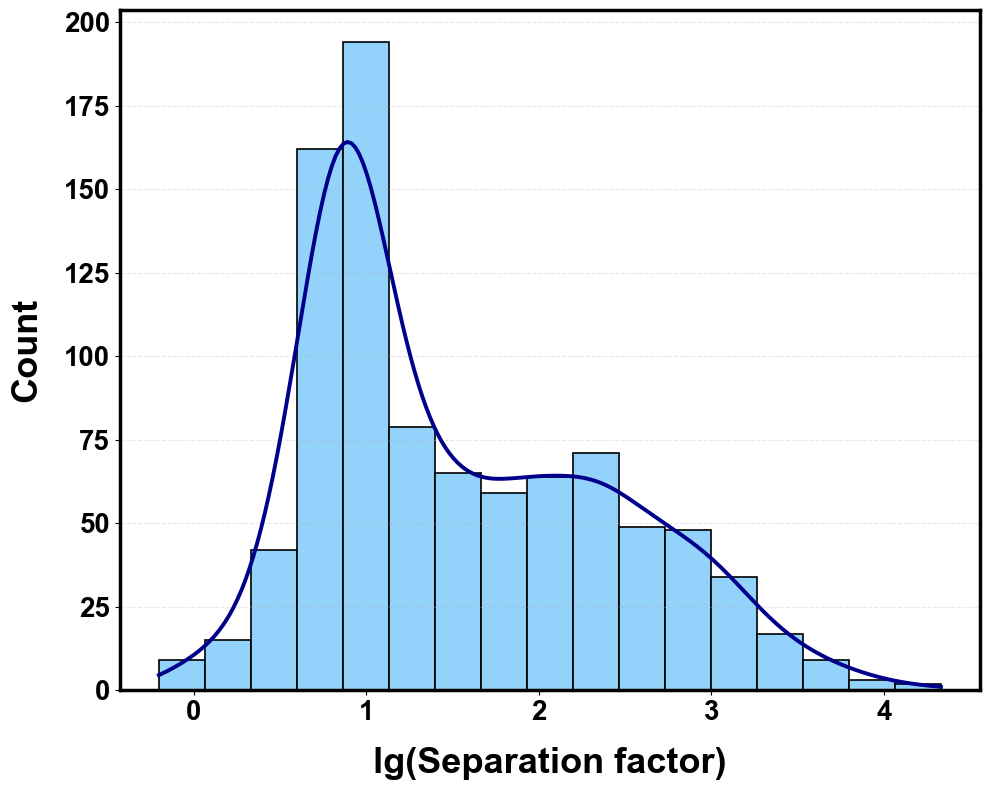


✅ 所有直方图绘制完成 (蓝色风格)！


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. 加载数据
# ==========================================
filename = '对数变换.csv' 
file_path = f'C:/Users/tinid/polymer/major revision/{filename}'

print(f"--- 正在读取数据: {file_path} ---")
try:
    df = pd.read_csv(file_path)
    # 容错加载
    if not os.path.exists(file_path) and os.path.exists(filename):
        df = pd.read_csv(filename)
except Exception as e:
    print(f"错误: 无法加载文件。{e}")
    exit()

print(f"成功加载，共 {len(df)} 行。")

# ==========================================
# 2. 自动筛选对数变换的列
# ==========================================
log_cols = [col for col in df.columns if 'log' in col.lower() or 'lg' in col.lower()]

if not log_cols:
    print("警告: 未找到含 log/lg 的列。")
    exit()

print(f"检测到以下列将绘制蓝色直方图: {log_cols}")

# ==========================================
# 3. 循环绘图 (统一蓝色)
# ==========================================
plt.rcParams['font.family'] = 'Arial'

for col in log_cols:
    print(f"正在绘制: {col} ...")
    
    # 创建画布
    plt.figure(figsize=(10, 8), facecolor='white')
    
    # 绘制直方图
    # 【修改点】统一使用淡蓝色
    ax = sns.histplot(
        df[col], 
        kde=True, 
        color='#87CEFA',   # <--- 淡蓝色 (LightSkyBlue)
        edgecolor='black', 
        linewidth=1.2,
        alpha=0.9
    )
    
    # 修改 KDE 曲线样式
    if ax.lines:
        ax.lines[0].set_color('#00008B') # <--- 深蓝色 (DarkBlue)
        ax.lines[0].set_linewidth(2.8)

    # 格式化 X 轴标签
    clean_name = col.replace('log_', '').replace('lg_', '').replace('_', ' ')
    x_label = f'lg({clean_name})'
    
    # 设置坐标轴标签
    plt.xlabel(x_label, fontsize=26, fontweight='bold', fontname='Arial', labelpad=15)
    plt.ylabel('Count', fontsize=26, fontweight='bold', fontname='Arial', labelpad=15)
    
    # 设置刻度样式
    plt.xticks(fontsize=20, fontweight='bold')
    plt.yticks(fontsize=20, fontweight='bold')
    
    # 加粗边框
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)
        spine.set_color('black')
    
    # 仅保留横向网格
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    # 保存图片
    safe_name = col.replace('/', '_').replace('\\', '_')
    plt.savefig(f'{safe_name}_blue_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n✅ 所有直方图绘制完成 (蓝色风格)！")

--- 正在读取数据: C:/Users/tinid/polymer/major revision/通量标准化数据_无独热_Log变换12.18.csv ---
成功加载，共 791 行。
检测到以下列将绘制红色直方图: ['log_Flux']
正在绘制: log_Flux ...


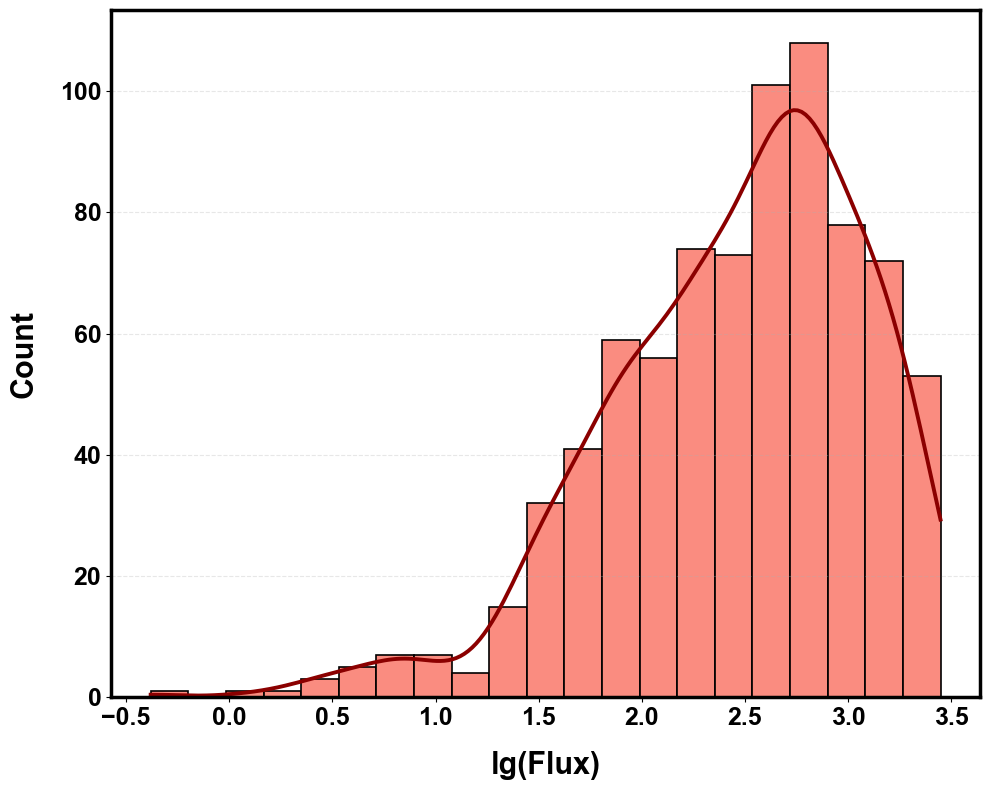


✅ 所有直方图绘制完成 (红色风格)！


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. 加载数据
# ==========================================
filename = '通量标准化数据_无独热_Log变换12.18.csv' 
file_path = f'C:/Users/tinid/polymer/major revision/{filename}'

print(f"--- 正在读取数据: {file_path} ---")
try:
    df = pd.read_csv(file_path)
    # 容错加载
    if not os.path.exists(file_path) and os.path.exists(filename):
        df = pd.read_csv(filename)
except Exception as e:
    print(f"错误: 无法加载文件。{e}")
    exit()

print(f"成功加载，共 {len(df)} 行。")

# ==========================================
# 2. 自动筛选对数变换的列
# ==========================================
log_cols = [col for col in df.columns if 'log' in col.lower() or 'lg' in col.lower()]

if not log_cols:
    print("警告: 未找到含 log/lg 的列。")
    exit()

print(f"检测到以下列将绘制红色直方图: {log_cols}")

# ==========================================
# 3. 循环绘图 (统一红色)
# ==========================================
plt.rcParams['font.family'] = 'Arial'

for col in log_cols:
    print(f"正在绘制: {col} ...")
    
    # 创建画布
    plt.figure(figsize=(10, 8), facecolor='white')
    
    # 绘制直方图
    # 【修改点1】将颜色改为红色系
    ax = sns.histplot(
        df[col], 
        kde=True, 
        color='#FA8072',   # <--- 修改为: 三文鱼红 (Salmon) / 浅红
        edgecolor='black', 
        linewidth=1.2,
        alpha=0.9
    )
    
    # 修改 KDE 曲线样式
    if ax.lines:
        ax.lines[0].set_color('#8B0000') # <--- 修改为: 深红色 (DarkRed)
        ax.lines[0].set_linewidth(2.8)

    # 格式化 X 轴标签
    clean_name = col.replace('log_', '').replace('lg_', '').replace('_', ' ')
    x_label = f'lg({clean_name})'
    
    # 设置坐标轴标签
    plt.xlabel(x_label, fontsize=22, fontweight='bold', fontname='Arial', labelpad=15)
    plt.ylabel('Count', fontsize=22, fontweight='bold', fontname='Arial', labelpad=15)
    
    # 设置刻度样式
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18, fontweight='bold')
    
    # 加粗边框
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)
        spine.set_color('black')
    
    # 仅保留横向网格
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    # 保存图片
    # 【修改点2】文件名后缀改为 red
    safe_name = col.replace('/', '_').replace('\\', '_')
    plt.savefig(f'{safe_name}_red_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n✅ 所有直方图绘制完成 (红色风格)！")

--- 正在读取数据: C:/Users/tinid/polymer/major revision/标准化数据_无独热编码通量.csv ---
成功加载，共 884 行。

正在对目标变量 'Flux' 进行 Log10 变换...
变换完成！
原始列 'Flux' 已删除。
新列 'log_Flux' 已生成。

✅ 最终训练数据已保存为: 对数变换通量.csv
--- 统计描述 ---
count    884.000000
mean       2.618885
std        0.714733
min        0.400883
25%        2.150864
50%        2.662191
75%        3.087207
max        4.698970
Name: log_Flux, dtype: float64

正在绘制分布图: log_Flux ...


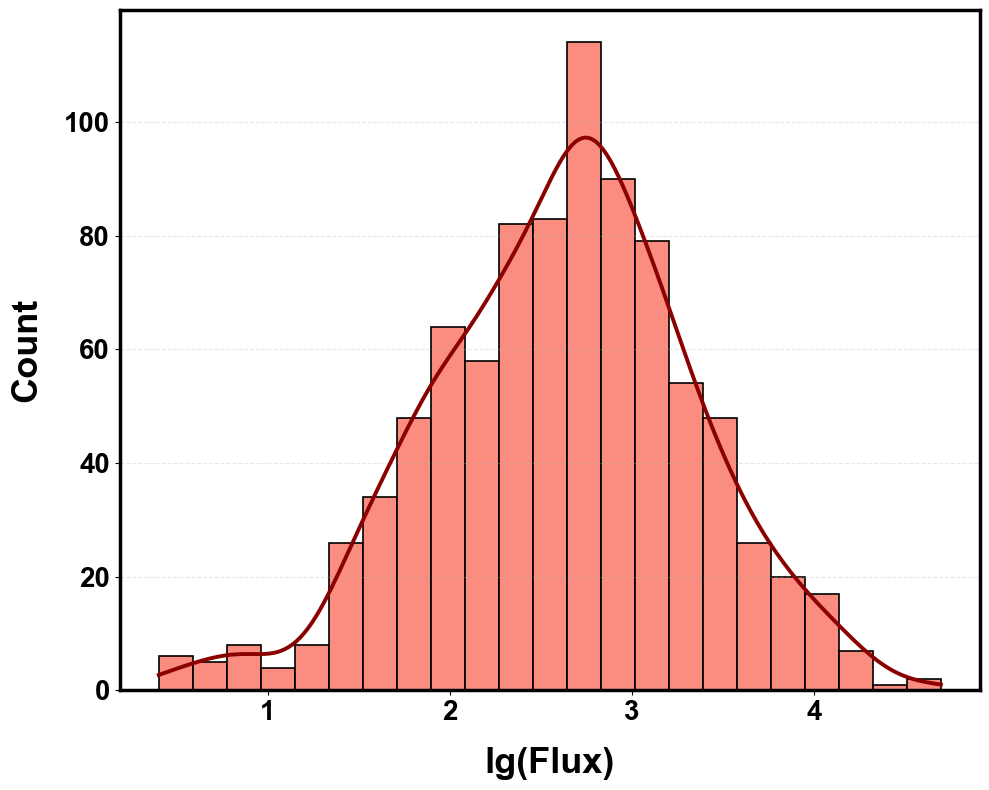

✅ 分布图已生成并保存！


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. 加载数据 (标准化后的数据)
# ==========================================
filename = '标准化数据_无独热编码通量.csv'
file_path = f'C:/Users/tinid/polymer/major revision/{filename}'
output_file = '对数变换通量.csv'

print(f"--- 正在读取数据: {file_path} ---")

try:
    df = pd.read_csv(file_path)
    # 容错机制：如果绝对路径找不到，尝试在当前目录找
    if df.empty and os.path.exists(filename):
        df = pd.read_csv(filename)
    print(f"成功加载，共 {len(df)} 行。")
except Exception as e:
    print(f"错误: 无法加载文件。请确保路径正确。\n{e}")
    exit()

# ==========================================
# 2. 执行 Log10 变换
# ==========================================
target_col = 'Flux'
new_target_col = 'log_Flux'

if target_col in df.columns:
    print(f"\n正在对目标变量 '{target_col}' 进行 Log10 变换...")
    
    # 检查是否有 <= 0 的值
    if (df[target_col] <= 0).any():
        n_removed = len(df[df[target_col] <= 0])
        print(f"警告: 发现 {n_removed} 行目标变量 <= 0，已移除。")
        df = df[df[target_col] > 0].copy()
    
    # 执行变换
    df[new_target_col] = np.log10(df[target_col])
    
    # 【关键步骤】删除原始列，防止数据泄露
    df = df.drop(columns=[target_col])
    
    print("变换完成！")
    print(f"原始列 '{target_col}' 已删除。")
    print(f"新列 '{new_target_col}' 已生成。")
else:
    print(f"错误: 数据中未找到列 '{target_col}'")
    exit()

# ==========================================
# 3. 保存处理后的数据
# ==========================================
df.to_csv(output_file, index=False)
print(f"\n✅ 最终训练数据已保存为: {output_file}")
print("--- 统计描述 ---")
print(df[new_target_col].describe())

# ==========================================
# 4. 验证变换效果 (红色风格可视化)
# ==========================================
print(f"\n正在绘制分布图: {new_target_col} ...")

# 设置全局字体
plt.rcParams['font.family'] = 'Arial'

# 创建画布
plt.figure(figsize=(10, 8), facecolor='white')

# 绘制直方图 (使用红色风格)
ax = sns.histplot(
    df[new_target_col], 
    kde=True, 
    color='#FA8072',   # 三文鱼红 (Salmon)
    edgecolor='black', 
    linewidth=1.2,
    alpha=0.9
)

# 修改 KDE 曲线样式 (深红色)
if ax.lines:
    ax.lines[0].set_color('#8B0000') 
    ax.lines[0].set_linewidth(2.8)

# 格式化 X 轴标签
x_label = 'lg(Flux)' # 直接使用数学符号格式

# 设置坐标轴标签
plt.xlabel(x_label, fontsize=26, fontweight='bold', fontname='Arial', labelpad=15)
plt.ylabel('Count', fontsize=26, fontweight='bold', fontname='Arial', labelpad=15)

# 设置刻度样式
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

# 加粗边框 (Spines)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
    spine.set_color('black')

# 仅保留横向网格
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()

# 保存图片
plt.savefig('Flux_log_transformed_red_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 分布图已生成并保存！")

--- 正在读取数据: C:/Users/tinid/polymer/major revision/对数变换通量.csv ---
成功加载，共 884 行。
正在处理: log_Flux


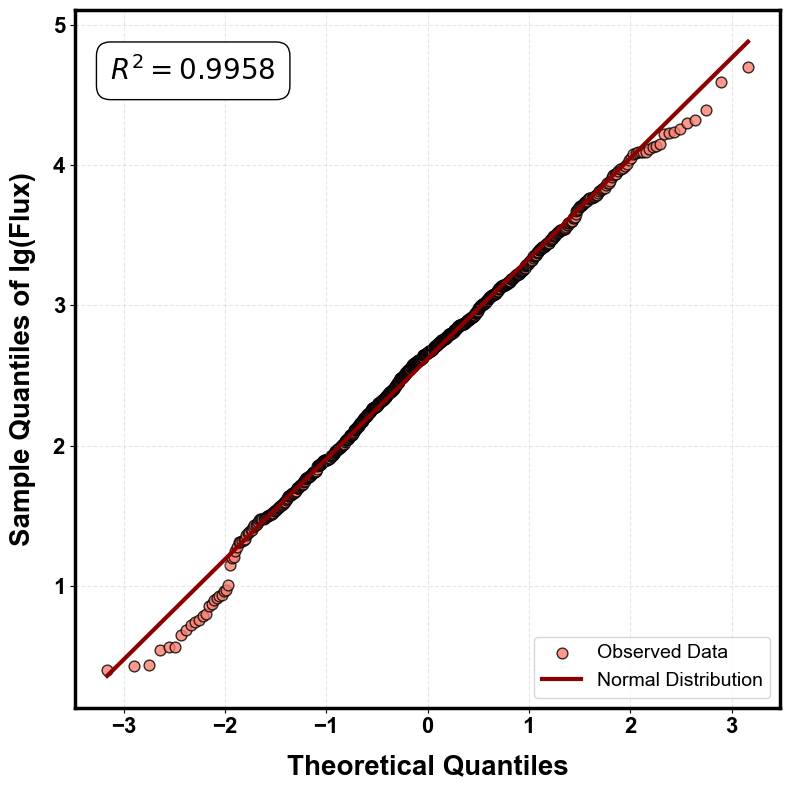

✅ Q-Q图已保存: log_Flux_QQplot_red.png (R2=0.9958)

所有 Q-Q 图绘制完成。


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# ==========================================
# 1. 加载数据
# ==========================================
# 请确保这里加载的是你刚刚保存的【对数变换后】的文件
filename = '对数变换通量.csv'  
file_path = f'C:/Users/tinid/polymer/major revision/{filename}'

print(f"--- 正在读取数据: {file_path} ---")
try:
    df = pd.read_csv(file_path)
    # 容错加载
    if df.empty and os.path.exists(filename):
        df = pd.read_csv(filename)
    print(f"成功加载，共 {len(df)} 行。")
except Exception as e:
    print(f"错误: 无法加载文件。\n{e}")
    exit()

# ==========================================
# 2. 定义 Q-Q Plot 绘图函数
# ==========================================
def draw_qq_plot(data, col_name, color_theme='red'):
    """
    绘制专业的 SCI 风格 Q-Q 图
    color_theme: 'red' (Flux) or 'blue' (Separation Factor)
    """
    plt.figure(figsize=(8, 8), facecolor='white')
    ax = plt.gca()
    
    # 设定颜色方案
    if color_theme == 'red':
        dot_color = '#FA8072'  # 散点颜色 (Salmon)
        line_color = '#8B0000' # 线条颜色 (DarkRed)
        title_suffix = '(Flux)'
    else:
        dot_color = '#87CEFA'  # 散点颜色 (LightSkyBlue)
        line_color = '#00008B' # 线条颜色 (DarkBlue)
        title_suffix = '(Sep. Factor)'

    # 计算 Q-Q 数据
    # probplot 返回: (osm, osr), (slope, intercept, r)
    (osm, osr), (slope, intercept, r) = stats.probplot(data, dist="norm", plot=None)
    
    # 1. 绘制散点 (数据点)
    plt.scatter(osm, osr, 
                color=dot_color, 
                edgecolor='black', 
                alpha=0.8, 
                s=60, 
                label='Observed Data')

    # 2. 绘制拟合线 (理论正态线)
    x_vals = np.array([min(osm), max(osm)])
    y_vals = slope * x_vals + intercept
    plt.plot(x_vals, y_vals, color=line_color, linewidth=3, linestyle='-', label='Normal Distribution')

    # 3. 标注 R^2 值 (非常重要，显示拟合程度)
    r_squared = r**2
    plt.text(0.05, 0.90, f'$R^2 = {r_squared:.4f}$', 
             transform=ax.transAxes, 
             fontsize=20, fontweight='bold', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    # 4. 格式化坐标轴
    clean_name = col_name.replace('log_', 'lg(').replace('lg_', 'lg(') + ')'
    if '(' not in clean_name: clean_name = f'lg({col_name})'
    
    plt.xlabel('Theoretical Quantiles', fontsize=20, fontweight='bold', fontname='Arial', labelpad=12)
    plt.ylabel(f'Sample Quantiles of {clean_name}', fontsize=20, fontweight='bold', fontname='Arial', labelpad=12)
    
    plt.xticks(fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')

    # 5. 边框加粗
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)
        spine.set_color('black')

    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(fontsize=14, loc='lower right')
    plt.tight_layout()
    
    # 保存
    save_name = f'{col_name}_QQplot_{color_theme}.png'
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Q-Q图已保存: {save_name} (R2={r_squared:.4f})")

# ==========================================
# 3. 自动检测列并绘图
# ==========================================
# 筛选 log 列
log_cols = [col for col in df.columns if 'log' in col.lower() or 'lg' in col.lower()]

plt.rcParams['font.family'] = 'Arial'

for col in log_cols:
    print(f"正在处理: {col}")
    
    # 简单的逻辑判断颜色
    if 'flux' in col.lower():
        theme = 'red'
    else:
        theme = 'blue' # 默认为蓝色 (通常是分离因子)
        
    draw_qq_plot(df[col], col, color_theme=theme)

print("\n所有 Q-Q 图绘制完成。")

--- 正在读取数据用于蓝色 Q-Q 图: C:/Users/tinid/polymer/major revision/对数变换.csv ---
成功加载，共 922 行。
正在绘制蓝色 Q-Q 图: log_Separation_factor


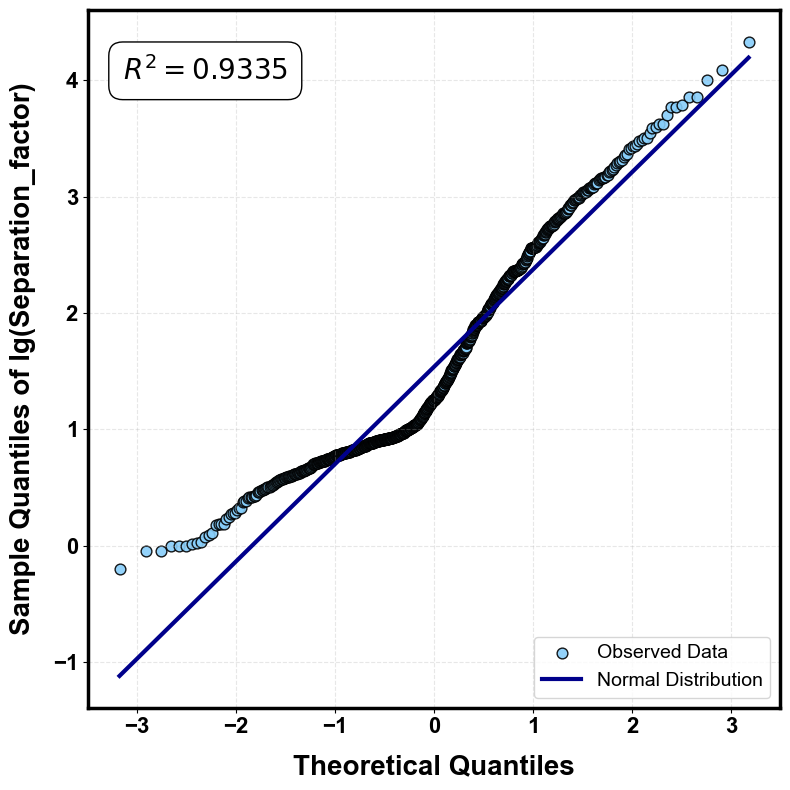

✅ 蓝色 Q-Q 图已保存: log_Separation_factor_QQplot_blue.png (R2=0.9335)

所有蓝色 Q-Q 图绘制完成。


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# ==========================================
# 1. 加载数据
# ==========================================
# 请确认文件名，如果是分离因子数据，请修改此处文件名
filename = '对数变换.csv'  
file_path = f'C:/Users/tinid/polymer/major revision/{filename}'

print(f"--- 正在读取数据用于蓝色 Q-Q 图: {file_path} ---")
try:
    df = pd.read_csv(file_path)
    # 容错加载
    if df.empty and os.path.exists(filename):
        df = pd.read_csv(filename)
    print(f"成功加载，共 {len(df)} 行。")
except Exception as e:
    print(f"错误: 无法加载文件。\n{e}")
    exit()

# ==========================================
# 2. 定义蓝色 Q-Q Plot 绘图函数
# ==========================================
def draw_blue_qq_plot(data, col_name):
    """
    绘制蓝色风格的 SCI Q-Q 图
    """
    plt.figure(figsize=(8, 8), facecolor='white')
    ax = plt.gca()
    
    # 【修改点】蓝色配色方案
    dot_color = '#87CEFA'  # 散点颜色 (LightSkyBlue)
    line_color = '#00008B' # 线条颜色 (DarkBlue)

    # 计算 Q-Q 数据
    (osm, osr), (slope, intercept, r) = stats.probplot(data, dist="norm", plot=None)
    
    # 1. 绘制散点
    plt.scatter(osm, osr, 
                color=dot_color, 
                edgecolor='black', 
                alpha=0.9, 
                s=60, 
                label='Observed Data')

    # 2. 绘制拟合线
    x_vals = np.array([min(osm), max(osm)])
    y_vals = slope * x_vals + intercept
    plt.plot(x_vals, y_vals, color=line_color, linewidth=3, linestyle='-', label='Normal Distribution')

    # 3. 标注 R^2 值
    r_squared = r**2
    plt.text(0.05, 0.90, f'$R^2 = {r_squared:.4f}$', 
             transform=ax.transAxes, 
             fontsize=20, fontweight='bold', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    # 4. 格式化坐标轴标签
    # 自动处理 log_ 前缀转数学符号
    clean_name = col_name.replace('log_', 'lg(').replace('lg_', 'lg(')
    if '(' in clean_name and not clean_name.endswith(')'):
        clean_name += ')'
    elif '(' not in clean_name:
        clean_name = f'lg({col_name})'
    
    plt.xlabel('Theoretical Quantiles', fontsize=20, fontweight='bold', fontname='Arial', labelpad=12)
    plt.ylabel(f'Sample Quantiles of {clean_name}', fontsize=20, fontweight='bold', fontname='Arial', labelpad=12)
    
    # 刻度设置
    plt.xticks(fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')

    # 5. 边框加粗
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)
        spine.set_color('black')

    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(fontsize=14, loc='lower right')
    plt.tight_layout()
    
    # 保存为蓝色后缀
    save_name = f'{col_name}_QQplot_blue.png'
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ 蓝色 Q-Q 图已保存: {save_name} (R2={r_squared:.4f})")

# ==========================================
# 3. 执行绘图
# ==========================================
# 自动筛选 log 列
log_cols = [col for col in df.columns if 'log' in col.lower() or 'lg' in col.lower()]

plt.rcParams['font.family'] = 'Arial'

if not log_cols:
    print("警告: 数据中没有找到 log 开头的列，请检查文件内容。")
else:
    for col in log_cols:
        print(f"正在绘制蓝色 Q-Q 图: {col}")
        draw_blue_qq_plot(df[col], col)

print("\n所有蓝色 Q-Q 图绘制完成。")